In [1]:
import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
from astropy.table import Table
from prfr import ProbabilisticRandomForestRegressor, split_arrays
from scipy.signal import savgol_filter

plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["figure.figsize"] = (11, 7)

In [2]:
data = Table.read("../data/bprp_apogee.fits").to_pandas().dropna()

In [3]:
data_ages = fits.open("../data/apogee_astroNN-DR17.fits.1")[1].data

In [4]:
cols = [
    "TEFF",
    "TEFF_ERR",
    "LOGG",
    "LOGG_ERR",
    "C_H",
    "C_H_ERR",
    "CI_H",
    "CI_H_ERR",
    "N_H",
    "N_H_ERR",
    "O_H",
    "O_H_ERR",
    "NA_H",
    "NA_H_ERR",
    "MG_H",
    "MG_H_ERR",
    "AL_H",
    "AL_H_ERR",
    "SI_H",
    "SI_H_ERR",
    "P_H",
    "P_H_ERR",
    "S_H",
    "S_H_ERR",
    "K_H",
    "K_H_ERR",
    "CA_H",
    "CA_H_ERR",
    "TI_H",
    "TI_H_ERR",
    "TIII_H",
    "TIII_H_ERR",
    "V_H",
    "V_H_ERR",
    "CR_H",
    "CR_H_ERR",
    "MN_H",
    "MN_H_ERR",
    "FE_H",
    "FE_H_ERR",
    "CO_H",
    "CO_H_ERR",
    "NI_H",
    "NI_H_ERR",
    "age",
    "age_total_error",
]

df_ages = pd.DataFrame(
    np.stack(
        (
            data_ages["source_id"],
            *[data_ages[i].astype("float32") for i in cols],
        )
    ).T
)
df_ages.columns = ["source_id"] + cols

In [5]:
data = data.drop(["fe_h", "alpha_m", "logg", "teff", "m_h"], axis=1)
data = pd.merge(
    data.drop_duplicates(), df_ages.drop_duplicates(), on="source_id"
).dropna()
data = data[data["LOGG"] < 3.5]
data = data[data["LOGG_ERR"] < 0.12]
data = data[(data["age_total_error"] / data["age"]) < 0.3]
data = data[
    (data["sfd_ebv"] < 0.1) & (data["FE_H"] > -5.0)
]  # consider cuts on other parameters?

In [88]:
# fmt: off
names_X = [ "bp_1", "bp_2", "bp_3", "bp_4", "bp_5", "bp_6", "bp_7", "bp_8", "bp_9", "bp_10", "bp_11", "bp_12", "bp_13", "bp_14", "bp_15", "bp_16", "bp_17", "bp_18", "bp_19", "bp_20", "bp_21", "bp_22", "bp_23", "bp_24", "bp_25", "bp_26", "bp_27", "bp_28", "bp_29", "bp_30", "bp_31", "bp_32", "bp_33", "bp_34", "bp_35", "bp_36", "bp_37", "bp_38", "bp_39", "bp_40", "bp_41", "bp_42", "bp_43", "bp_44", "bp_45", "bp_46", "bp_47", "bp_48", "bp_49", "bp_50", "bp_51", "bp_52", "bp_53", "bp_54", "bp_55", "rp_1", "rp_2", "rp_3", "rp_4", "rp_5", "rp_6", "rp_7", "rp_8", "rp_9", "rp_10", "rp_11", "rp_12", "rp_13", "rp_14", "rp_15", "rp_16", "rp_17", "rp_18", "rp_19", "rp_20", "rp_21", "rp_22", "rp_23", "rp_24", "rp_25", "rp_26", "rp_27", "rp_28", "rp_29", "rp_30", "rp_31", "rp_32", "rp_33", "rp_34", "rp_35", "rp_36", "rp_37", "rp_38", "rp_39", "rp_40", "rp_41", "rp_42", "rp_43", "rp_44", "rp_45", "rp_46", "rp_47", "rp_48", "rp_49", "rp_50", "rp_51", "rp_52", "rp_53", "rp_54", "rp_55", ] 
names_eX = [ "bpe_1", "bpe_2", "bpe_3", "bpe_4", "bpe_5", "bpe_6", "bpe_7", "bpe_8", "bpe_9", "bpe_10", "bpe_11", "bpe_12", "bpe_13", "bpe_14", "bpe_15", "bpe_16", "bpe_17", "bpe_18", "bpe_19", "bpe_20", "bpe_21", "bpe_22", "bpe_23", "bpe_24", "bpe_25", "bpe_26", "bpe_27", "bpe_28", "bpe_29", "bpe_30", "bpe_31", "bpe_32", "bpe_33", "bpe_34", "bpe_35", "bpe_36", "bpe_37", "bpe_38", "bpe_39", "bpe_40", "bpe_41", "bpe_42", "bpe_43", "bpe_44", "bpe_45", "bpe_46", "bpe_47", "bpe_48", "bpe_49", "bpe_50", "bpe_51", "bpe_52", "bpe_53", "bpe_54", "bpe_55", "rpe_1", "rpe_2", "rpe_3", "rpe_4", "rpe_5", "rpe_6", "rpe_7", "rpe_8", "rpe_9", "rpe_10", "rpe_11", "rpe_12", "rpe_13", "rpe_14", "rpe_15", "rpe_16", "rpe_17", "rpe_18", "rpe_19", "rpe_20", "rpe_21", "rpe_22", "rpe_23", "rpe_24", "rpe_25", "rpe_26", "rpe_27", "rpe_28", "rpe_29", "rpe_30", "rpe_31", "rpe_32", "rpe_33", "rpe_34", "rpe_35", "rpe_36", "rpe_37", "rpe_38", "rpe_39", "rpe_40", "rpe_41", "rpe_42", "rpe_43", "rpe_44", "rpe_45", "rpe_46", "rpe_47", "rpe_48", "rpe_49", "rpe_50", "rpe_51", "rpe_52", "rpe_53", "rpe_54", "rpe_55", ] 
names_Y = ["FE_H", "MG_H", "LOGG", "TEFF", "age"] 
names_eY = ["FE_H_ERR", "MG_H_ERR", "LOGG_ERR", "TEFF_ERR", "age_total_error"] 
names_norm = ["gaiaedr3_phot_g_mean_mag"]

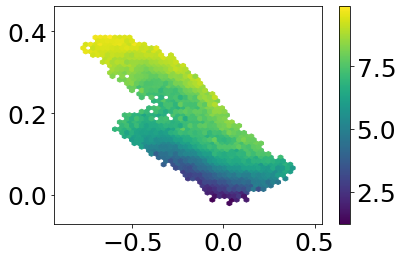

In [8]:
plt.hexbin(
    data["FE_H"], data["MG_H"] - data["FE_H"], C=data["age"], gridsize=50, mincnt=5
)
plt.colorbar()

In [9]:
normalize = lambda x, n: x / (10 ** (8.5 - n / 2.5))

In [10]:
features = normalize(data[names_X].to_numpy(), data[names_norm].to_numpy())
efeatures = normalize(data[names_eX].to_numpy(), data[names_norm].to_numpy())
labels = data[names_Y].to_numpy()
# labels[:, -1] = np.log(labels[:, -1])  # log ages
labels[:, 1] = labels[:, 1] - labels[:, 0]  # turn mg/h into mg/fe
elabels = data[names_eY].to_numpy()
elabels[:, 1] = np.sqrt(elabels[:, 1] ** 2 + elabels[:, 0] ** 2)

train, test, valid = split_arrays(
    features,
    efeatures,
    labels,
    elabels,
    test_size=0.2,
    valid_size=0.2,
)

In [11]:
model = ProbabilisticRandomForestRegressor(
    n_jobs=-1,
)

In [12]:
model.fit(
    train[0],
    train[2],
    eX=train[1],
    eY=train[3],
)

Fitting model:   0%|          | 0/100 [00:00<?, ?it/s]

ProbabilisticRandomForestRegressor(n_jobs=-1)

In [13]:
model.calibrate(valid[0], valid[2], eX=valid[1], eY=valid[3], apply_bias=False)
model.fit_bias(valid[0], valid[2], eX=valid[1])

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

Unscaling labels:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
%%time

preds = model.predict(test[0], eX=test[1])
residual = test[2] - np.mean(preds, axis=-1)
print(residual.mean(axis=0))
print(residual.std(axis=0))

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

Unscaling labels:   0%|          | 0/100 [00:00<?, ?it/s]

[-1.51401917e-03  1.05680755e-05 -3.59666293e-03 -1.08217102e+00
  4.92516782e-03]
[ 0.06035371  0.04284684  0.11457412 39.68327078  0.87813098]
CPU times: user 2.9 s, sys: 677 ms, total: 3.58 s
Wall time: 2.2 s


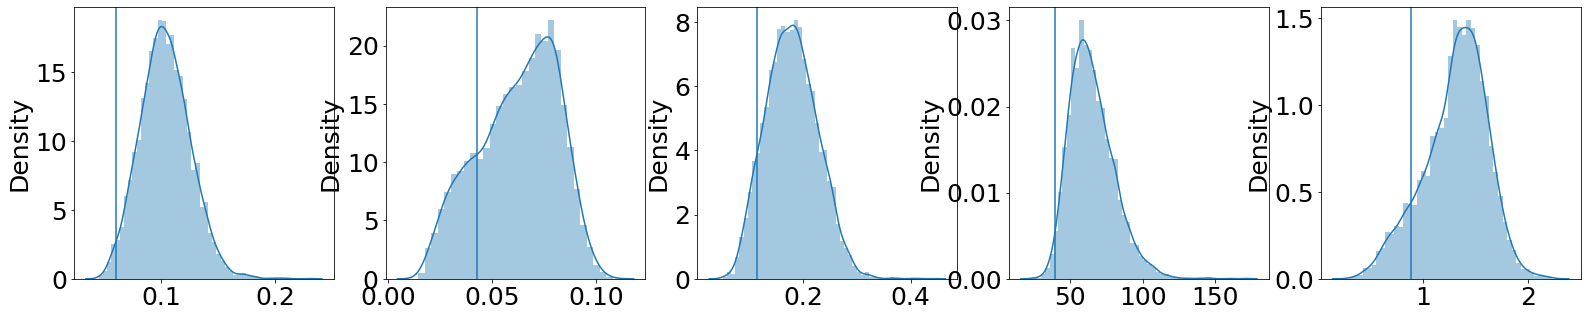

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(27, 5))
biases = np.std(test[2][:, :, None] - preds, axis=-1)
for i in range(5):
    sns.distplot(biases[:, i], ax=ax[i])
    ax[i].axvline(residual.std(axis=0)[i])
# print(residual.mean(axis=0), residual.std(axis=0))

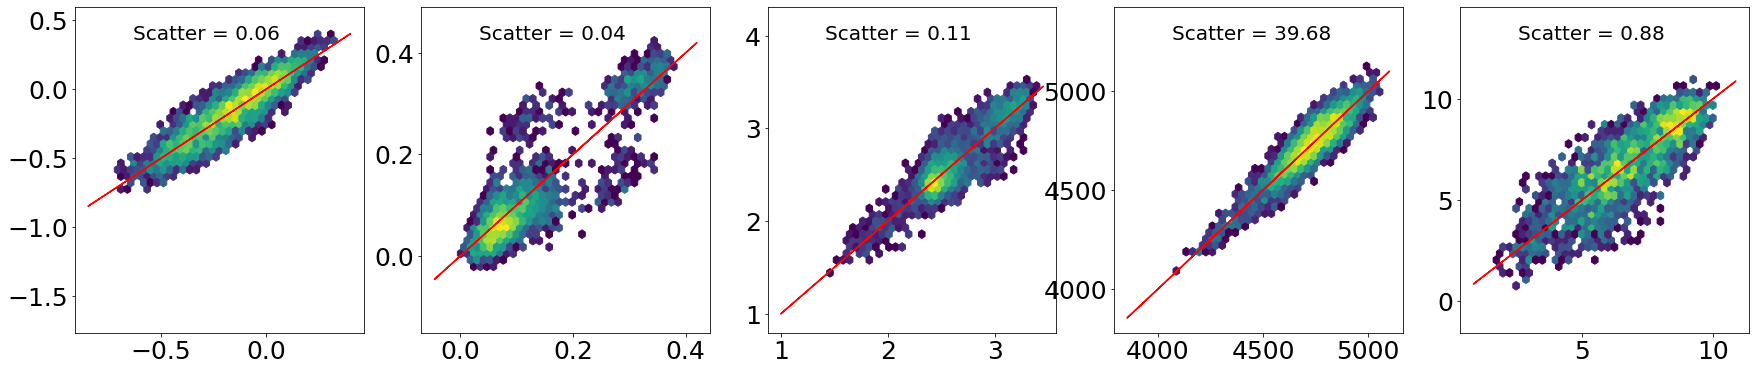

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6))
for i in range(5):
    ax[i].hexbin(
        test[2][:, i],
        preds[:, i, 0],
        gridsize=40,
        mincnt=5,
        norm=matplotlib.colors.LogNorm(),
    )
    ax[i].plot(test[2][:, i], test[2][:, i], c="r", zorder=5)
    ax[i].annotate(
        f"Scatter = {residual.std(axis=0)[i]:.2f}",
        (0.2, 0.9),
        xycoords="axes fraction",
        fontsize=20,
    )

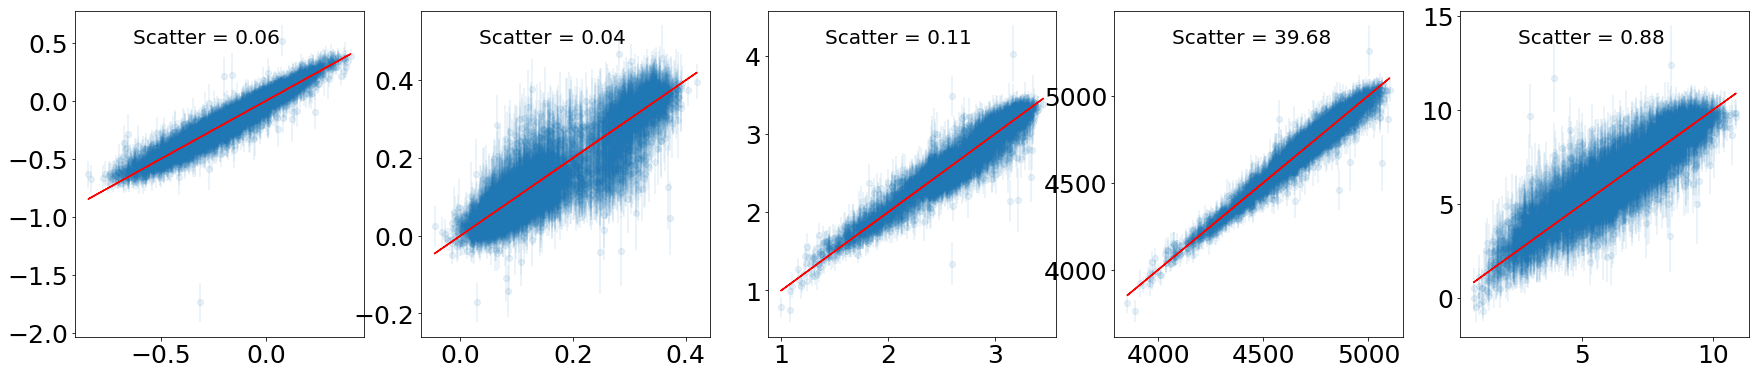

In [18]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6))
for i in range(5):
    ax[i].errorbar(
        test[2][:, i].flatten(),
        np.median(preds, axis=-1)[:, i],
        yerr=preds.std(axis=-1)[:, i],
        ls="none",
        marker="o",
        alpha=0.1,
    )
    ax[i].plot(test[2][:, i], test[2][:, i], c="r", zorder=5)
    ax[i].annotate(
        f"Scatter = {residual.std(axis=0)[i]:.2f}",
        (0.2, 0.9),
        xycoords="axes fraction",
        fontsize=20,
    )

(-1.2, 1.2)

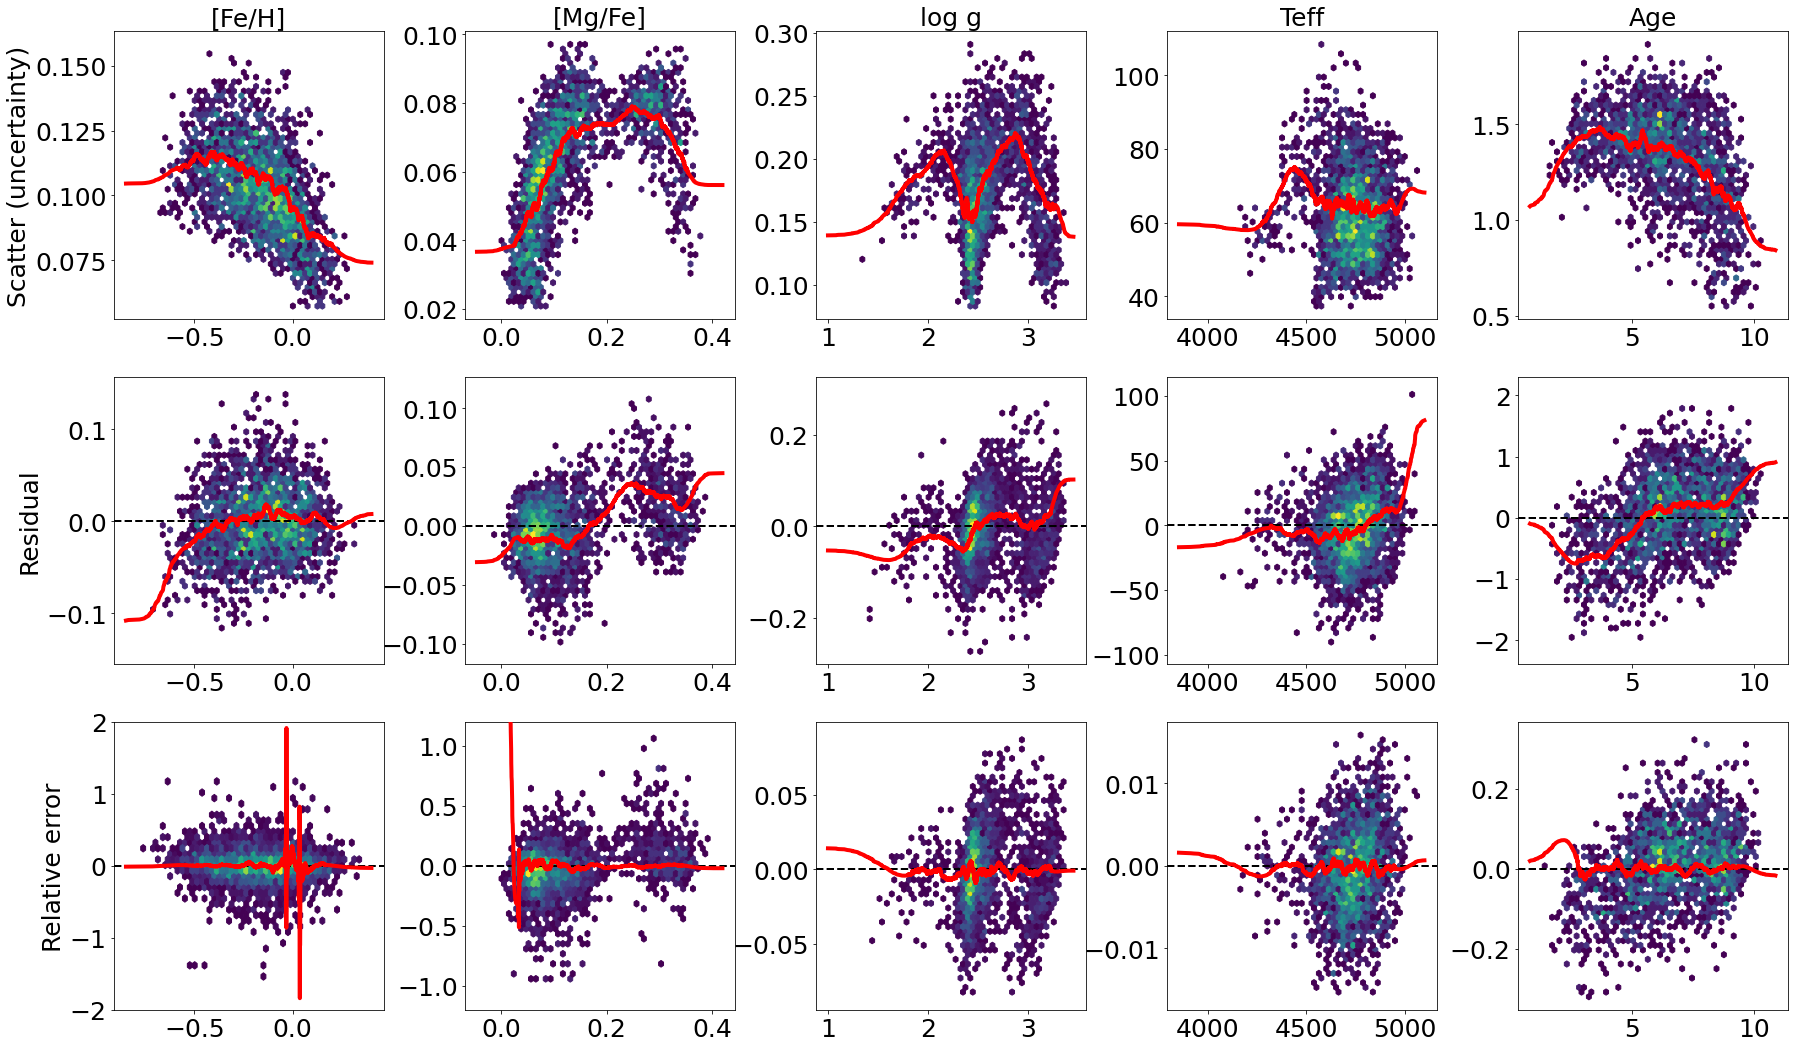

In [81]:
fig = plt.figure(figsize=(30, 18))
gs = fig.add_gridspec(nrows=3, ncols=5, wspace=0.3)
ax = np.stack(
    [np.array([fig.add_subplot(gs[i, j]) for j in range(5)]) for i in range(3)]
)

for i in range(5):
    ax[0, i].hexbin(
        test[2][:, i],
        preds[:, i].std(axis=-1),
        mincnt=3,
        gridsize=50,
        extent=[
            test[2][:, i].min(),
            test[2][:, i].max(),
            *np.quantile(preds[:, i].std(axis=-1), [0.01, 0.99]),
        ],
    )
    sortidx = np.argsort(test[2][:, i])
    ax[0, i].plot(
        test[2][:, i][sortidx],
        savgol_filter(preds[:, i].std(axis=-1)[sortidx], 400, 3),
        c="r",
        zorder=6,
        lw=4,
    )

    ax[1, i].hexbin(
        test[2][:, i],
        residual[:, i],
        mincnt=3,
        gridsize=50,
        extent=[
            test[2][:, i].min(),
            test[2][:, i].max(),
            *np.quantile(residual[:, i], [0.01, 0.99]),
        ],
    )
    ax[1, i].axhline(0, c="k", ls="--", lw=2, zorder=5)
    sortidx = np.argsort(test[2][:, i])
    ax[1, i].plot(
        test[2][:, i][sortidx],
        savgol_filter(residual[:, i][sortidx], 600, 3),
        c="r",
        zorder=6,
        lw=4,
    )

    y2 = residual[:, i] / test[2][:, i][sortidx]
    ax[2, i].hexbin(
        test[2][:, i],
        y2,
        mincnt=3,
        gridsize=50,
        extent=[
            test[2][:, i].min(),
            test[2][:, i].max(),
            *np.quantile(y2, [0.03, 0.97]),
        ],
    )
    ax[2, i].axhline(0, c="k", ls="--", lw=2, zorder=5)
    sortidx = np.argsort(test[2][:, i])
    ax[2, i].plot(
        test[2][:, i][sortidx],
        savgol_filter(y2, 600, 3),
        c="r",
        zorder=6,
        lw=4,
    )

ax[0, 0].set_ylabel("Scatter (uncertainty)")
ax[1, 0].set_ylabel("Residual")
ax[2, 0].set_ylabel("Relative error")

ax[0, 0].set_title("[Fe/H]")
ax[0, 1].set_title("[Mg/Fe]")
ax[0, 2].set_title("log g")
ax[0, 3].set_title("Teff")
ax[0, 4].set_title("Age")

# manual adjustments
ax[2, 0].set_ylim(-2.0, 2.0)
ax[2, 1].set_ylim(-1.2, 1.2)

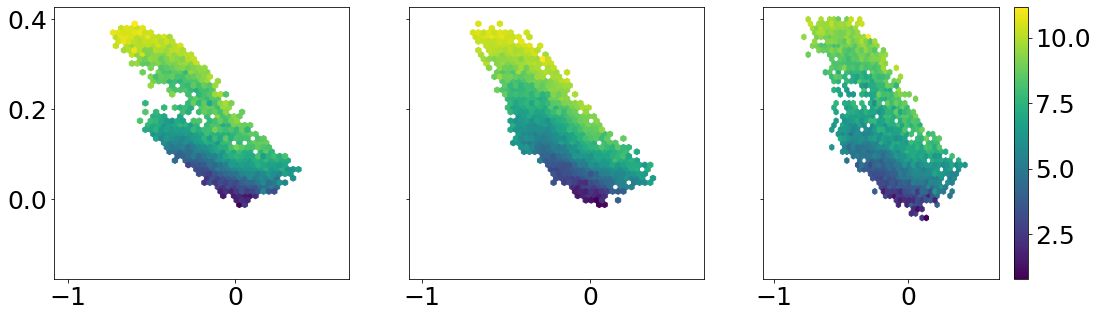

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
args = dict(gridsize=50, mincnt=2, extent=[-1.0, 0.6, -0.15, 0.4])
ax[0].hexbin(test[2][:, 0], test[2][:, 1], C=test[2][:, 4], **args)
ax[1].hexbin(
    preds[:, 0].mean(axis=-1),
    preds[:, 1].mean(axis=-1),
    C=preds[:, 4].mean(axis=-1),
    **args
)
hb = ax[2].hexbin(preds[:, 0, 0], preds[:, 1, 0], C=preds[:, 4, 0], **args)
plt.colorbar(hb, ax=ax[2])

(3.7, 0.8)

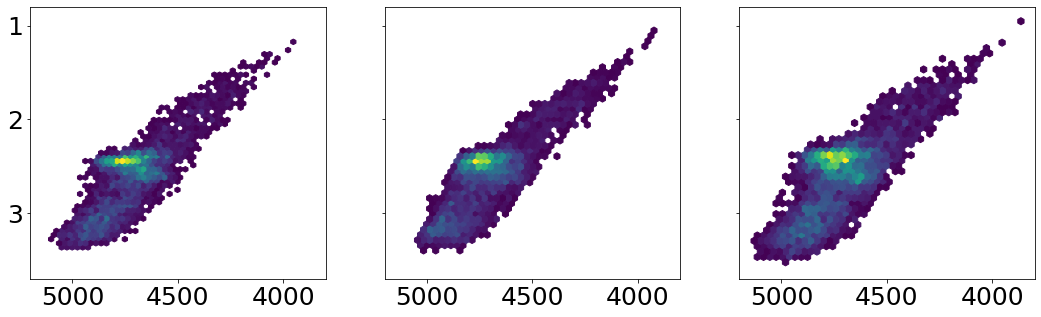

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
args = dict(gridsize=50, mincnt=2)
ax[0].hexbin(test[2][:, 3], test[2][:, 2], **args)
ax[1].hexbin(preds[:, 3].mean(axis=-1), preds[:, 2].mean(axis=-1), **args)
ax[2].hexbin(preds[:, 3, 0], preds[:, 2, 0], **args)

for a in ax:
    a.invert_xaxis()
    a.invert_yaxis()
ax[0].set_xlim(5200, 3800)
ax[0].set_ylim(3.7, 0.8)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[2].set_xlim(ax[0].get_xlim())
ax[2].set_ylim(ax[0].get_ylim())

(3.7, 0.8)

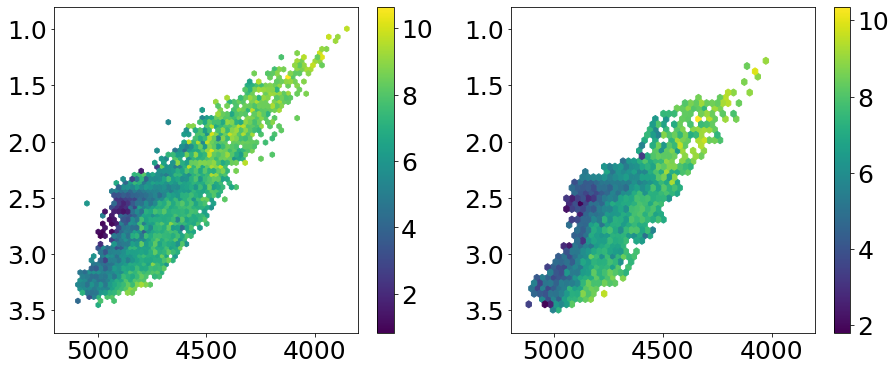

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

hb0 = ax[0].hexbin(test[2][:, 3], test[2][:, 2], C=test[2][:, -1], gridsize=60)
plt.colorbar(hb0, ax=ax[0])
hb1 = ax[1].hexbin(
    preds[:, 3, 0],
    preds[:, 2, 0],
    C=preds[:, -1, 0],
    mincnt=2,
    gridsize=60,
)
plt.colorbar(hb1, ax=ax[1])

for a in ax:
    a.invert_xaxis()
    a.invert_yaxis()
ax[0].set_xlim(5200, 3800)
ax[0].set_ylim(3.7, 0.8)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())

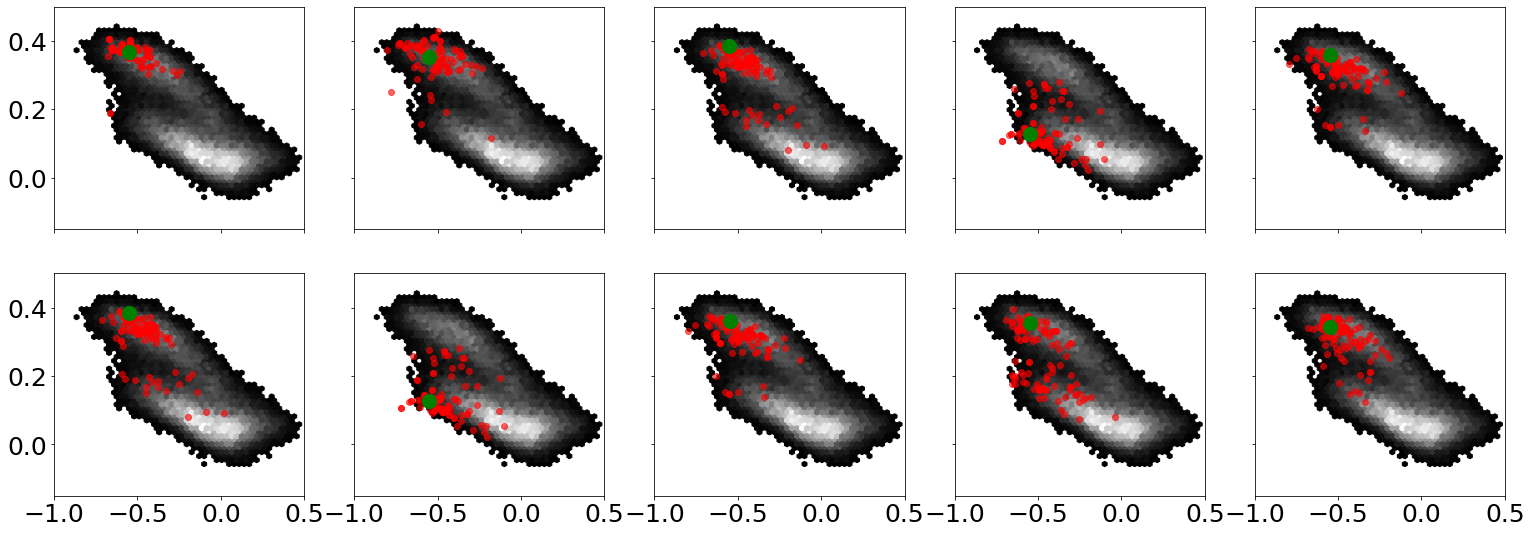

In [60]:
fig, ax = plt.subplots(2, 5, figsize=(26, 9), sharex=True, sharey=True)
sortidx = np.argsort((test[2][:, 0] - -0.55) ** 2)
args = dict(extent=[-1.0, 0.5, -0.15, 0.5], mincnt=5, gridsize=50, cmap="gray")
for i in range(2):
    for j in range(5):
        idx = i * 2 + j
        ax[i][j].scatter(
            preds[sortidx[idx]][0], preds[sortidx[idx]][1], alpha=0.6, c="r", zorder=5
        )
        ax[i][j].scatter(
            test[2][sortidx[idx], 0], test[2][sortidx[idx], 1], s=200, c="g", zorder=6
        )
        ax[i][j].hexbin(preds[:, 0, :10].flatten(), preds[:, 1, :10].flatten(), **args)
        ax[i][j].set_xlim(-1.0, 0.5)
        ax[i][j].set_ylim(-0.15, 0.5)

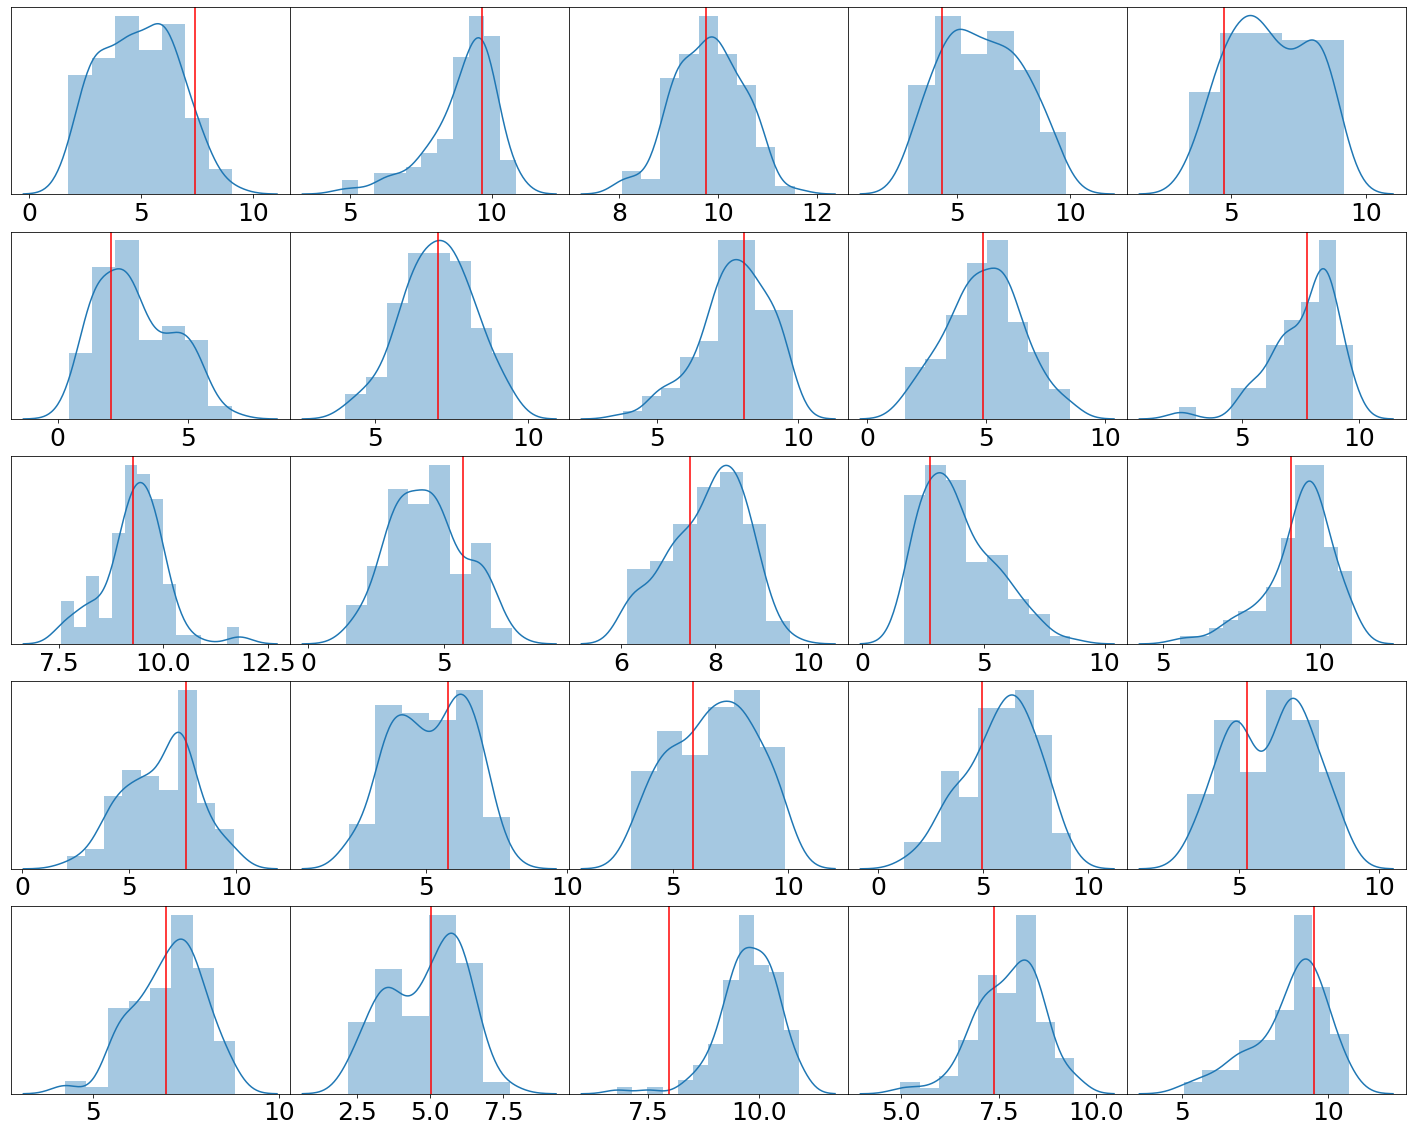

In [50]:
fig = plt.figure(figsize=(25, 20))

for i in range(5):
    for j in range(5):
        idx = i * 5 + j + 1
        ax = fig.add_subplot(5, 5, idx)
        sns.distplot(preds[idx][-1].flatten(), ax=ax)
        ax.axvline(test[2][idx, -1], c="r")
        ax.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.0)

In [54]:
plt.figure(figsize=(11, 7))

axis = 0

H, x_edges, y_edges = np.histogram2d(
    test[2].flatten(), np.median(preds, axis=1), bins=(200, 200)
)
x_bins = (x_edges[1:] + x_edges[:-1]) / 2.0
y_bins = (y_edges[1:] + y_edges[:-1]) / 2.0
H_norm = H / H.sum(axis=axis).reshape((-1, 1) if axis == 1 else (1, -1))
H_norm[H_norm < 1e-3] = np.nan

plt.imshow(
    H_norm.T,
    norm=matplotlib.colors.LogNorm(),
    origin="lower",
    extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],
)
if axis == 1:
    mean = np.nansum(H_norm.T * x_bins, axis=1) / np.nansum(H_norm.T, axis=1)
else:
    mean = np.nansum(H_norm * y_bins, axis=1) / np.nansum(H_norm, axis=1)
# plt.plot(x_bins if axis == 0 else y_bins, mean, c="r", zorder=5, lw=2)

cdf = np.nancumsum(H_norm if axis == 0 else H_norm.T, axis=1) / np.nansum(
    H_norm if axis == 0 else H_norm.T, axis=1
).reshape(-1, 1)
# plt.plot(cdf, x_bins)
vals = []
for c in cdf:
    vals.append(np.interp([0.16, 0.5, 0.84], c, x_bins if axis == 0 else y_bins))
vals = np.stack(vals).T
plt.plot(x_bins if axis == 0 else y_bins, vals[1])
plt.fill_between(
    x_bins if axis == 0 else y_bins, vals[0], vals[2], alpha=0.5, color="gray"
)
plt.colorbar()

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

<Figure size 792x504 with 0 Axes>

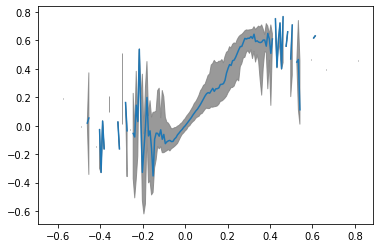